In [1]:
# Import modules
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn.model_selection import GridSearchCV

# Import PySwarms
import pyswarms as ps

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data = pd.read_csv('parkinsons.csv', delimiter=',')

In [3]:
X = data.drop(columns=['name', 'status'])
y = data['status']
X = np.array(X)
y = np.array(y)
y.dtype

dtype('int64')

In [4]:
# num_features = X.shape[1]

In [5]:
from sklearn.neighbors import KNeighborsClassifier
parameters = {'n_neighbors':range(2,16), 'weights':('uniform', 'distance')}
knn = KNeighborsClassifier(algorithm='auto')
classifier = GridSearchCV(knn, parameters)

In [6]:
def f_per_particle(m, alpha):
    """Computes for the objective function per particle

    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to mask features.
    alpha: float (default is 0.5)
        Constant weight for trading-off classifier performance
        and number of features

    Returns
    -------
    numpy.ndarray
        Computed objective function
    """
    total_features = X.shape[1]
    # Get the subset of the features from the binary mask
    if np.count_nonzero(m) == 0:
        X_subset = preprocessing.scale(X)
    else:
        X_subset = preprocessing.scale(X[:,m==1])
    # Perform classification and store performance in P
    classifier.fit(X_subset, y)
    P = (classifier.predict(X_subset) == y).mean()
    # Compute for the objective function
    j = (alpha * (1.0 - P)
        + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))

    return j

In [7]:
def f(x, alpha=0.88):
    """Higher-level method to do classification in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

In [8]:
# Initialize swarm, arbitrary
options = {'c1': 0.5, 'c2': 0.5, 'w':0.9, 'k': 30, 'p':2}

# Call instance of PSO
dimensions = X.shape[1] # dimensions should be the number of features

optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=1000)

2020-08-06 16:25:09,776 - pyswarms.discrete.binary - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|███████████████████████████████████████████████████████████|1000/1000, best_cost=0.00545
2020-08-06 20:38:23,736 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.00545454545454545, best pos: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


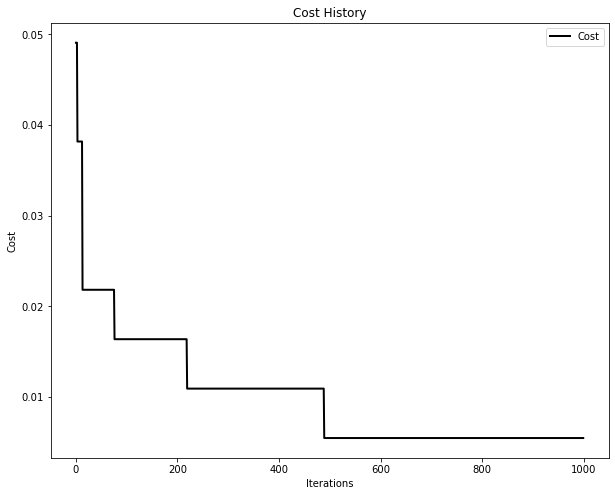

In [9]:
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
import matplotlib.pyplot as plt

# Plot the cost
plot_cost_history(optimizer.cost_history)
plt.show()

In [10]:
# Get the selected features from the final positions
X_selected_features = X[:,pos==1]  # subset

In [11]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_selected_features, y, test_size=0.3, random_state=0)

In [12]:
x_val, x_test, y_val, y_test = model_selection.train_test_split(x_test, y_test, test_size=0.5, random_state=0)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
parameters = {'n_neighbors':range(2,16), 'weights':('uniform', 'distance')}
knn = KNeighborsClassifier(algorithm='auto')
clf = GridSearchCV(knn, parameters)

In [14]:
X_selected_features.shape

(195, 21)

In [15]:
x_train = preprocessing.scale(x_train)
x_train.shape

(136, 21)

In [16]:
clf.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 16),
                         'weights': ('uniform', 'distance')})

In [17]:
clf.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [18]:
x_val = preprocessing.scale(x_val)
clf.score(x_val, y_val)

1.0

In [19]:
from sklearn.metrics import confusion_matrix
x_test = preprocessing.scale(x_test)
y_true = y_test
y_pred = clf.predict(x_test)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
print("Specificity is : " , specificity)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print("Accuracy is : " , accuracy)
sensitivity = tp / (tp + fn)
print("Sensitivity is : " , sensitivity)

Specificity is :  1.0
Accuracy is :  0.9666666666666667
Sensitivity is :  0.9565217391304348


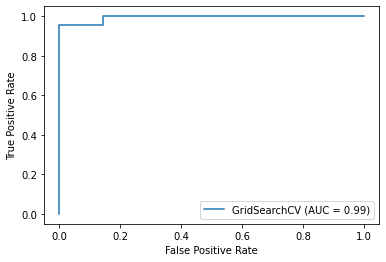

In [21]:
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm

metrics.plot_roc_curve(clf, x_test, y_test) 
# plt.title("ROC Curve for KNN Classifier with BPSO based Feature Selection")
plt.show()  